In [1]:
import pandas as pd
import pickle
import networkx as nx
import sys
import os

# Structural

In [2]:

sys.path.append(os.path.abspath('..'))
from src.features import get_pagerank, get_approx_betweenness, get_clustering_coefficient, get_harmonic_centrality

from src import load_or_compute

# 1. Load the graph from the pickle file
# Make sure the path is correct relative to where you run this script
with open("../data/processed/amazon_graph.pickle", "rb") as f:
    G_loaded = pickle.load(f)

recompute = False

In [31]:

df_handpagerank = load_or_compute("../data/processed/pagerank_scores.csv", get_pagerank , True , G = G_loaded, force_cpu = False)
# Now all functions (build_index_map, calculate_pagerank, etc.) are available in memory
#prscores = get_prscores(G_loaded)
display(sum(df_handpagerank["pagerank"].values))
#df_handpagerank = pd.DataFrame(list(prscores.items()), columns=['ASIN', 'MyHandPageRank'])
display(df_handpagerank.head(20))
# Save to CSV
#df_handpagerank.to_csv("../data/processed/handpagerank_scores.csv", index=False)

Computing
cpu
💾 Saving to ../data/processed/pagerank_scores.csv...


np.float64(0.9854412932845636)

,pagerank
ASIN,
0827229534,5.332977e-06
0738700797,9.438284e-06
0842328327,6.925232e-07
1577943082,1.400741e-06
0486220125,4.671820e-07
B00000AU3R,5.403461e-06
0231118597,3.781384e-06
0375709363,4.671820e-07
0871318237,4.671820e-07


In [4]:


df_bet = load_or_compute("../data/processed/bet_scores.csv",get_approx_betweenness,recompute,G=G_loaded,k=1000) 
display(df_bet.head(5))
# Save to CSV



# Now you can use the scores
print(f"Computed bet cent for {len(df_bet)} nodes.")

File found.


,Betweenness
ASIN,
0827229534,5.321784e-05
0738700797,6.280808e-09
0842328327,0.000000e+00
1577943082,0.000000e+00
0486220125,0.000000e+00


Computed bet cent for 334843 nodes.


In [5]:


df_clus = load_or_compute("../data/processed/clus_scores.csv",get_clustering_coefficient,recompute,G = G_loaded)
display(df_clus.head(5))

# Now you can use the scores
print(f"Computed cc for {len(df_bet)} nodes.")

File found.


,ClusteringCoefficient
ASIN,
0827229534,0.290323
0738700797,0.563953
0842328327,0.400000
1577943082,0.888889
0486220125,0.333333


Computed cc for 334843 nodes.


In [6]:
# Compute Harmonic scores and save them to a csv file
df_harmonic_scores = load_or_compute("../data/processed/harm_scores.csv",get_harmonic_centrality,recompute,G= G_loaded, version="GPU")
#df_harmonic_scores.to_csv("../data/processed/harm_scores.csv", index=False)

display(df_harmonic_scores.head(5))
print(f"Computed hc for {len(df_harmonic_scores)} nodes.")

File found.


,HarmonicCentrality
ASIN,
0827229534,10890.978000
0738700797,9056.977000
0842328327,2.840921
1577943082,5.111011
0486220125,0.000000


Computed hc for 334843 nodes.


### Now we work on df


In [7]:

#df_pagerank = pd.DataFrame.from_dict(pagerank_scores, orient='index', columns=['PageRank'])
#df_clus = pd.DataFrame.from_dict(clus_scores, orient='index', columns=['ClusteringCoeff'])
#df_bet = pd.DataFrame.from_dict(bet_scores, orient='index', columns=['Betweenness'])


data_frames = [df_handpagerank,df_clus,df_bet,df_harmonic_scores]

df_final = pd.concat(data_frames,axis=1)



In [8]:

salesrank_dict = nx.get_node_attributes(G_loaded, 'salesrank')

# 2. Convert to DataFrame
df_salesrank = pd.DataFrame.from_dict(salesrank_dict, orient='index', columns=['salesrank'])
df_salesrank.index.name = 'ASIN'

# 3. Join to df_final
# This performs a left join on the index (ASIN)
df_final = df_final.join(df_salesrank)

# Check the result
display(df_final.head())

,pagerank,ClusteringCoefficient,Betweenness,HarmonicCentrality,salesrank
ASIN,,,,,
0827229534,5.332977e-06,0.290323,5.321784e-05,10890.978000,396585.0
0738700797,9.438284e-06,0.563953,6.280808e-09,9056.977000,168596.0
0842328327,6.925232e-07,0.400000,0.000000e+00,2.840921,631289.0
1577943082,1.400741e-06,0.888889,0.000000e+00,5.111011,455160.0
0486220125,4.671820e-07,0.333333,0.000000e+00,0.000000,188784.0


In [9]:
df_final.to_csv("../data/processed/structural_metrics.csv")

## Clustering

In [10]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

features = ['pagerank','Betweenness','ClusteringCoefficient','HarmonicCentrality','salesrank']
X=df_final[features]

#non ci dovrebbero essere NaN ma per sicurezza
X=X.fillna(0)

In [11]:
X.head()

,pagerank,Betweenness,ClusteringCoefficient,HarmonicCentrality,salesrank
ASIN,,,,,
0827229534,5.332977e-06,5.321784e-05,0.290323,10890.978000,396585.0
0738700797,9.438284e-06,6.280808e-09,0.563953,9056.977000,168596.0
0842328327,6.925232e-07,0.000000e+00,0.400000,2.840921,631289.0
1577943082,1.400741e-06,0.000000e+00,0.888889,5.111011,455160.0
0486220125,4.671820e-07,0.000000e+00,0.333333,0.000000,188784.0


Standardize

In [12]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=4)
clusters = kmeans.fit_predict(X_scaled)

df_final['cluster_kmeans']= clusters

#questo stampa quanti nodi per ogni gruppo
print(df_final['cluster_kmeans'].value_counts())

#maybe we can save it

cluster_kmeans
1    162482
0     87904
2     81029
3      3428
Name: count, dtype: int64


confronto con gruppi 

In [13]:
#aggiungo il gruppo 
groups_dict = nx.get_node_attributes(G_loaded, 'group')

# 2. Converti in un DataFrame (assicurandoti che l'indice sia l'ASIN)
df_groups = pd.DataFrame.from_dict(groups_dict, orient='index', columns=['group'])
df_groups.index.name = 'ASIN'

# 3. Unisci al tuo df_final
# join è intelligente: allinea automaticamente gli indici (ASIN)
df_final = df_final.join(df_groups)

In [14]:
import seaborn as sns 
import matplotlib.pyplot as plt

crosstab = pd.crosstab(df_final['cluster_kmeans'], df_final['group'])

print(crosstab)

group            Book    DVD  Music  Video
cluster_kmeans                            
0               67910   4730  13890   1374
1               97394  10611  40504  13973
2               80971      0     58      0
3                2641    402    372     13


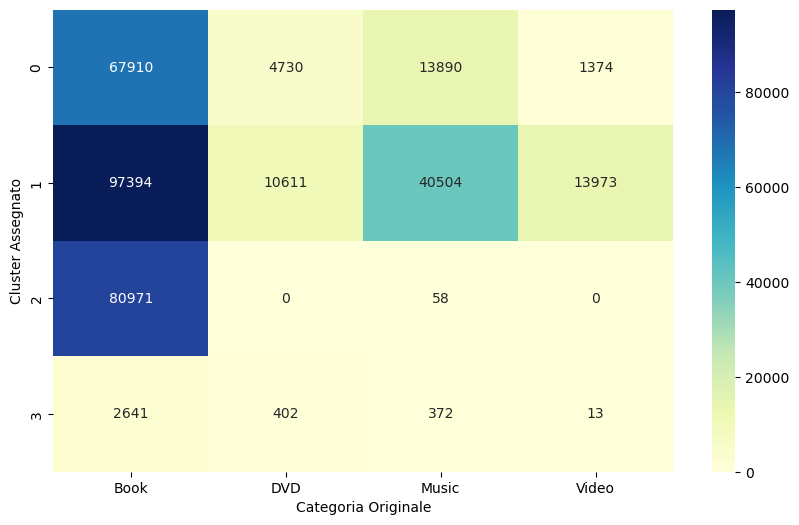

In [15]:
plt.figure(figsize=(10,6))
sns.heatmap(crosstab, annot=True, fmt='d',cmap='YlGnBu')
plt.xlabel('Categoria Originale')
plt.ylabel('Cluster Assegnato')
plt.show()

# Embeddings 

TODO: call load or compute or a similar function
load the embeddings in a df

In [16]:
embedding_file_path = "../data/processed/embeddings.csv" 
df_embeddings = pd.read_csv(embedding_file_path, index_col=0)

print("embedding dimension:", df_embeddings.shape)
display(df_embeddings.head())


embedding dimension: (334843, 128)


,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,...,emb_118,emb_119,emb_120,emb_121,emb_122,emb_123,emb_124,emb_125,emb_126,emb_127
ASIN,,,,,,,,,,,,,,,,,,,,,
0827229534,0.088292,-0.124796,0.110967,-0.200329,0.075371,0.027049,0.079700,0.112991,0.131683,0.230764,...,0.455229,-0.391443,0.619291,-0.062505,-0.105565,0.246981,0.102540,-0.078417,-0.179820,-0.046816
0738700797,-0.051625,0.303609,-0.008047,-0.181592,0.463362,0.218762,-0.054979,-0.424648,0.619461,0.363503,...,-0.369866,0.216292,-0.079631,-0.144787,0.159695,-0.430492,-0.037573,0.627891,-0.019264,-0.021633
0842328327,-0.094732,0.003826,-0.067005,0.102680,-0.231441,0.059075,0.137641,-0.017522,0.040568,-0.041383,...,-0.017546,-0.007458,0.096496,-0.003165,0.075457,0.072070,-0.048270,0.099321,-0.095226,-0.023939
1577943082,0.349904,-0.259240,0.252159,0.123891,0.239037,0.103163,0.082212,0.104584,-0.061214,-0.071249,...,0.063734,0.042164,0.015107,-0.174672,-0.032913,-0.036417,-0.043947,0.019164,0.506197,-0.093707
0486220125,-0.165557,0.119667,-0.050203,0.051494,0.123005,-0.055614,-0.023031,0.025098,0.072406,-0.067332,...,-0.045086,-0.340472,0.042844,-0.029869,-0.014213,0.124896,0.059724,-0.103773,-0.138744,0.025901


In [17]:
from sklearn.preprocessing import StandardScaler, normalize

X = df_embeddings.values

X_norm = normalize(X) 

kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_norm)

df_embeddings['cluster_kmeans'] = clusters

print("\nConteggio Cluster:")
print(df_embeddings['cluster_kmeans'].value_counts())




Conteggio Cluster:
cluster_kmeans
3    155757
1     93647
2     64340
0     21099
Name: count, dtype: int64


In [18]:
df_final = df_final.join(df_embeddings['cluster_kmeans'], rsuffix='_emb')
df_final.head()

,pagerank,ClusteringCoefficient,Betweenness,HarmonicCentrality,salesrank,cluster_kmeans,group,cluster_kmeans_emb
ASIN,,,,,,,,
0827229534,5.332977e-06,0.290323,5.321784e-05,10890.978000,396585.0,0,Book,2
0738700797,9.438284e-06,0.563953,6.280808e-09,9056.977000,168596.0,0,Book,3
0842328327,6.925232e-07,0.400000,0.000000e+00,2.840921,631289.0,2,Book,3
1577943082,1.400741e-06,0.888889,0.000000e+00,5.111011,455160.0,1,Book,2
0486220125,4.671820e-07,0.333333,0.000000e+00,0.000000,188784.0,1,Book,3


In [19]:
crosstab = pd.crosstab(df_final['cluster_kmeans_emb'], df_final['group'])

print(crosstab)

group                 Book   DVD  Music  Video
cluster_kmeans_emb                            
0                     6300  6534   3052   5213
1                    81094  2028   7881   2644
2                    58767   889   3338   1346
3                   102755  6292  40553   6157


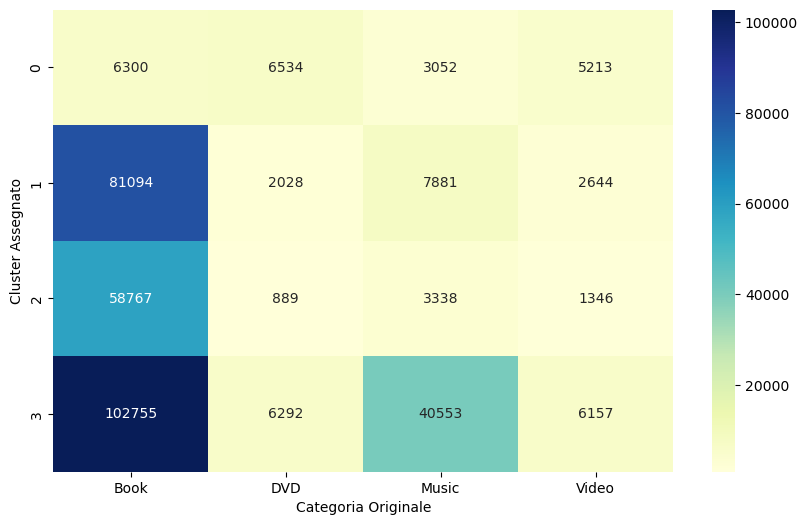

In [20]:
plt.figure(figsize=(10,6))
sns.heatmap(crosstab, annot=True, fmt='d',cmap='YlGnBu')
plt.xlabel('Categoria Originale')
plt.ylabel('Cluster Assegnato')
plt.show()

## Hybrid


In [30]:
data_frames = [df_handpagerank,df_clus,df_bet,df_harmonic_scores,df_salesrank]

df_struct = pd.concat(data_frames,axis=1)
df_struct.head()

,pagerank,ClusteringCoefficient,Betweenness,HarmonicCentrality,salesrank
ASIN,,,,,
0827229534,5.332977e-06,0.290323,5.321784e-05,10890.978000,396585.0
0738700797,9.438284e-06,0.563953,6.280808e-09,9056.977000,168596.0
0842328327,6.925232e-07,0.400000,0.000000e+00,2.840921,631289.0
1577943082,1.400741e-06,0.888889,0.000000e+00,5.111011,455160.0
0486220125,4.671820e-07,0.333333,0.000000e+00,0.000000,188784.0


In [29]:
scaler = StandardScaler()
X_struct = scaler.fit_transform(df_final[['pagerank', 'Betweenness', 'ClusteringCoefficient', 'HarmonicCentrality', 'salesrank']])

In [23]:
#ho ricaricaricato gli embeddings ma si puo usare il df di prima 
df_emb = pd.read_csv("../data/processed/embeddings.csv", index_col=0)

In [28]:
df_hybrid_raw = df_struct.join(df_emb, how='inner', lsuffix='_struct', rsuffix='_emb')

# Separiamo le colonne per poter applicare normalizzazioni diverse
cols_struct = df_struct.columns
cols_emb = df_emb.columns

# Se hai colonne 'non-feature' (come 'group' o 'title'), rimuovile dalle liste
cols_struct = [c for c in cols_struct if c not in ['group', 'title', 'ASIN']]
# cols_emb dovrebbe contenere solo numeri (0, 1, ... 127)

print(f"Feature Strutturali: {len(cols_struct)}")
print(f"Dimensioni Embedding: {len(cols_emb)}")
print(f"Totale Nodi Allineati: {len(df_hybrid_raw)}")



# Opzione A: MinMax Scaling (Tutto tra 0 e 1) - Spesso preferito per ibridi
#scaler = MinMaxScaler()

# Opzione B: StandardScaler (Media 0, Var 1)
scaler = StandardScaler()

# Applichiamo lo scaler all'intero dataset concatenato
# (Oppure puoi scalare le due parti separatamente se vuoi pesi diversi)
X_hybrid = scaler.fit_transform(df_hybrid_raw[cols_struct + list(cols_emb)].fillna(0))


df_hybrid_features = pd.DataFrame(
    X_hybrid, 
    index=df_hybrid_raw.index, 
    columns=list(cols_struct) + list(cols_emb)
)

display(df_hybrid_features.head())



Feature Strutturali: 5
Dimensioni Embedding: 128
Totale Nodi Allineati: 334843


,pagerank,ClusteringCoefficient,Betweenness,HarmonicCentrality,salesrank,emb_0,emb_1,emb_2,emb_3,emb_4,...,emb_118,emb_119,emb_120,emb_121,emb_122,emb_123,emb_124,emb_125,emb_126,emb_127
ASIN,,,,,,,,,,,,,,,,,,,,,
0827229534,0.339984,-0.096736,0.396195,2.043145,0.373610,0.502729,-0.705111,0.626321,-1.133368,0.425375,...,2.590484,-2.214366,3.520082,-0.354644,-0.600271,1.401653,0.579355,-0.438834,-1.012054,-0.264233
0738700797,0.923979,0.883981,-0.173138,1.597225,-0.409131,-0.293690,1.718335,-0.045297,-1.027363,2.614326,...,-2.103656,1.224270,-0.453533,-0.821452,0.905875,-2.445250,-0.211712,3.525366,-0.108592,-0.122193
0842328327,-0.320138,0.296357,-0.173206,-0.604203,1.179404,-0.539058,0.022491,-0.378007,0.580915,-1.305583,...,-0.099233,-0.041734,0.547810,-0.017992,0.427572,0.408454,-0.272106,0.558732,-0.536036,-0.135200
1577943082,-0.219391,2.048577,-0.173206,-0.603651,0.574712,1.991846,-1.465648,1.423092,0.700917,1.348739,...,0.363186,0.239033,0.085086,-0.990998,-0.187753,-0.207569,-0.247699,0.108846,2.848223,-0.528713
0486220125,-0.352194,0.057418,-0.173206,-0.604894,-0.339821,-0.942200,0.677793,-0.283191,0.291329,0.694115,...,-0.255914,-1.925966,0.242780,-0.169491,-0.081574,0.708417,0.337619,-0.581146,-0.780916,0.145914


In [25]:

kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
clusters = kmeans.fit_predict(df_hybrid_features)

# Aggiungiamo i cluster al df originale per analisi
#df_results = df_hybrid_raw.copy()
df_final['cluster_hybrid'] = clusters

# Se hai la colonna 'group' (ground truth), analizza i risultati
if 'group' in df_final.columns:
    print("\nConfronto con Ground Truth:")
    print(pd.crosstab(df_final['cluster_hybrid'], df_final['group']))





Confronto con Ground Truth:
group             Book   DVD  Music  Video
cluster_hybrid                            
0               112383  6134  17835   6840
1                69648  4632  24710   7320
2                 2914   826    398     22
3                63971  4151  11881   1178


In [26]:
df_final.head()

,pagerank,ClusteringCoefficient,Betweenness,HarmonicCentrality,salesrank,cluster_kmeans,group,cluster_kmeans_emb,cluster_hybrid
ASIN,,,,,,,,,
0827229534,5.332977e-06,0.290323,5.321784e-05,10890.978000,396585.0,0,Book,2,3
0738700797,9.438284e-06,0.563953,6.280808e-09,9056.977000,168596.0,0,Book,3,3
0842328327,6.925232e-07,0.400000,0.000000e+00,2.840921,631289.0,2,Book,3,0
1577943082,1.400741e-06,0.888889,0.000000e+00,5.111011,455160.0,1,Book,2,1
0486220125,4.671820e-07,0.333333,0.000000e+00,0.000000,188784.0,1,Book,3,0


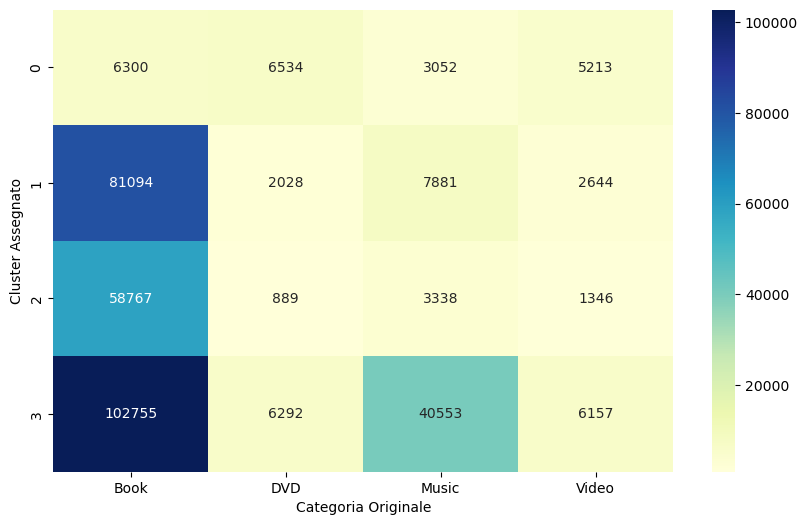

In [27]:
plt.figure(figsize=(10,6))
sns.heatmap(crosstab, annot=True, fmt='d',cmap='YlGnBu')
plt.xlabel('Categoria Originale')
plt.ylabel('Cluster Assegnato')
plt.show()